Using the XGBoost to model the bandgap for the dataset Stoich 45 intersection.

In [78]:
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Using the dataset Stoich45_FeatureSelected_dataset

In [79]:
train_dataset=pd.read_csv('../../Data/datasets_main/Stoich45_FeatureSelected_dataset.csv')  


In [80]:
train_dataset.head()

,atomic_num_standard_deviation,atomic_num_max,group_num_mean,period_num_mean,electronegativity_min,electron_affinity_mean,electron_affinity_geometric_mean,electron_affinity_standard_deviation,melting_mean,melting_geometric_mean,...,density_geometric_mean,density_standard_deviation,density_max,ionization_energy_mean,ionization_energy_geometric_mean,ionization_energy_standard_deviation,ionization_energy_max,ionization_energy_geometric_min,outputs.hse06.bandgap,MOF
0,5.689851,29.0,7.960000,1.600000,1.90,100.252000,82.167123,45.559861,1143.143600,107.487344,...,4.182460,1912.665927,8960.0,1233.652000,1223.402105,146.933016,1402.3,745.5,3.751390,qmof-0000295
1,3.088689,19.0,13.700000,2.050000,0.82,110.030000,72.816144,57.821122,1199.022000,206.066393,...,15.205775,1023.803409,2260.0,1218.510000,1187.405501,219.174061,1402.3,418.8,3.014584,qmof-000512e
2,6.272068,30.0,10.363636,1.818182,1.65,100.818182,0.000000,58.491030,1114.843636,141.329527,...,8.874182,1680.181346,7140.0,1230.522727,1221.752785,142.324105,1402.3,906.4,3.284171,qmof-00052d0
3,8.169828,48.0,8.687500,1.656250,1.69,110.787500,0.000000,42.372240,1231.431562,122.519183,...,5.589511,1726.258029,8650.0,1228.065625,1221.424040,122.525772,1313.9,867.8,5.170849,qmof-0006638
4,4.436880,27.0,9.097561,1.658537,1.88,104.460976,82.484786,49.421674,1552.056341,186.153480,...,10.509249,1648.227778,8900.0,1219.541463,1210.807020,139.686543,1402.3,760.4,3.978235,qmof-002580c


In [81]:

train_dataset.drop(columns=['MOF'], inplace=True)
# Rename the target column to 'HSE06Bandgap' for consistency
train_dataset.rename(columns={'outputs.hse06.bandgap': 'HSE06Bandgap'}, inplace=True)

##### Define the Feature dataset and the target.

In [82]:
X= train_dataset.drop(columns=['HSE06Bandgap'])  # Features
y = train_dataset['HSE06Bandgap']  # Target variable

#### Generate the model XGBRegressor

In [83]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

RMSE scores for each fold: [0.52847441 0.51539061 0.52522727 0.53499399]
Mean RMSE: 0.5260215698715321
Std Dev of RMSE: 0.007074052906333124
Fractional Errors for each fold: [0.18763289 0.18941628 0.18772459 0.18941928]
Mean Fractional Error: 0.18854826212610312
Std Dev of Fractional Error: 0.0008701230113200895


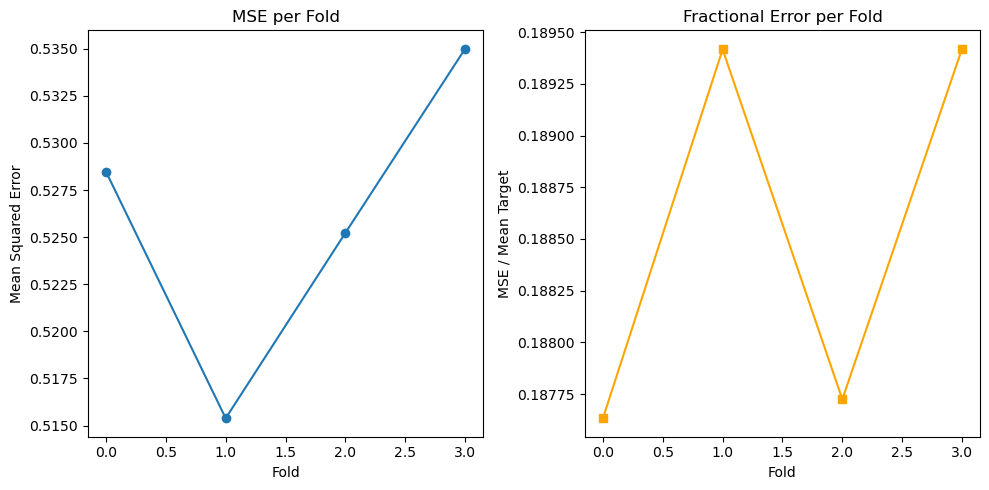

In [84]:

kfold = KFold(n_splits=4, shuffle=True, random_state=1234)
# Fit the model using cross-validation and get mean CV MSE and fractional error
def get_mean_cv_mse_and_frac_error(model, X, y, kfold):
    validation_target_means = [y[test_index].mean() for _, test_index in kfold.split(X)]
    mses = -cross_val_score(
        model,
        X, y,
        cv=kfold, scoring='neg_mean_squared_error',
        n_jobs=4
    )
    frac_errors = np.sqrt(mses) / validation_target_means

    return (mses, np.sqrt(mses) / validation_target_means)
mses, frac_errors = get_mean_cv_mse_and_frac_error(model, X, y, kfold)
print("RMSE scores for each fold:", mses)
print("Mean RMSE:", mses.mean())
print("Std Dev of RMSE:", mses.std())
print("Fractional Errors for each fold:", frac_errors)
print("Mean Fractional Error:", frac_errors.mean())
print("Std Dev of Fractional Error:", frac_errors.std())
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mses, marker='o')
plt.title("MSE per Fold")
plt.xlabel("Fold")
plt.ylabel("Mean Squared Error")

plt.subplot(1, 2, 2)
plt.plot(frac_errors, marker='s', color='orange')
plt.title("Fractional Error per Fold")
plt.xlabel("Fold")
plt.ylabel("MSE / Mean Target")
plt.tight_layout()
plt.show()
# Ensure the model is fitted before calculating CV MSE and fractional error




## Measures the improvement in loss (e.g., reduction in MSE) that each split on a feature provides.

Final Model Performance:
Root Mean Squared Error (RMSE): 0.5996208907679479
Mean Absolute Error (MAE): 0.46190316912861157
R-squared (R2): 0.6863265788573243


Text(0.5, 1.0, 'Feature Importance (Gain) - XGBoost')

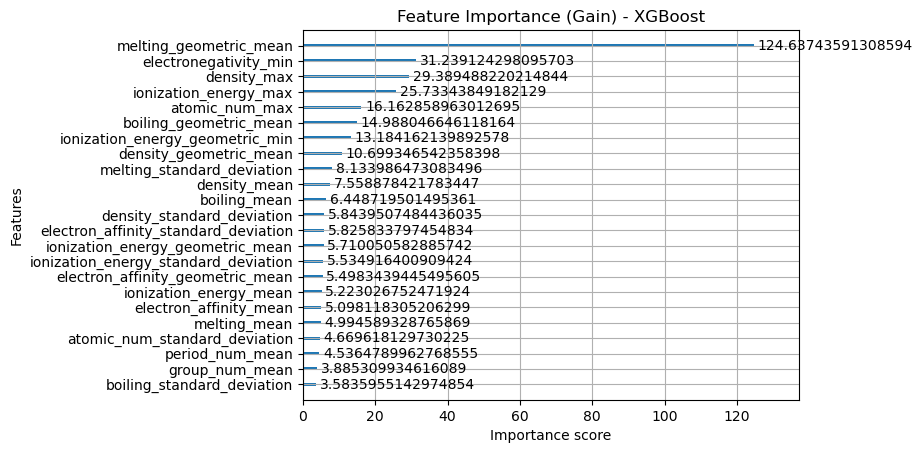

In [85]:

model.fit(X, y)
RMSE = np.sqrt(mean_squared_error(y, model.predict(X)))
MAE= mean_absolute_error(y, model.predict(X))
R2= model.score(X, y)
print("Final Model Performance:")
print("Root Mean Squared Error (RMSE):", RMSE)
print("Mean Absolute Error (MAE):", MAE)
print("R-squared (R2):", R2)
plot_importance(model, importance_type='gain')
plt.title("Feature Importance (Gain) - XGBoost")


## The average coverage (number of samples) that go through splits on that feature.



Text(0.5, 1.0, 'Feature Importance by COVER in XGBoost')

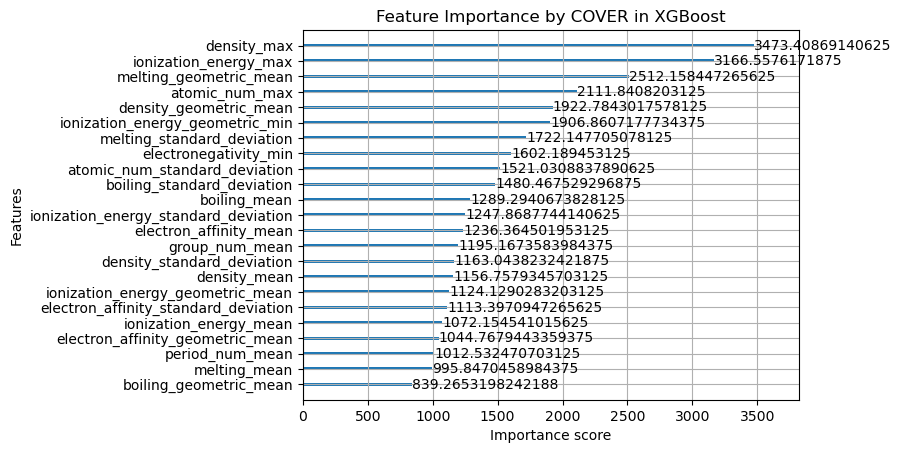

In [86]:
plot_importance(model, importance_type='cover')
plt.title("Feature Importance by COVER in XGBoost")

## Counts how many times a feature is used for splitting across all trees.
## The more frequently a feature is used to create a split (at any level), the higher its importance.

Text(0.5, 1.0, 'Feature Importance by Weight in XGBoost')

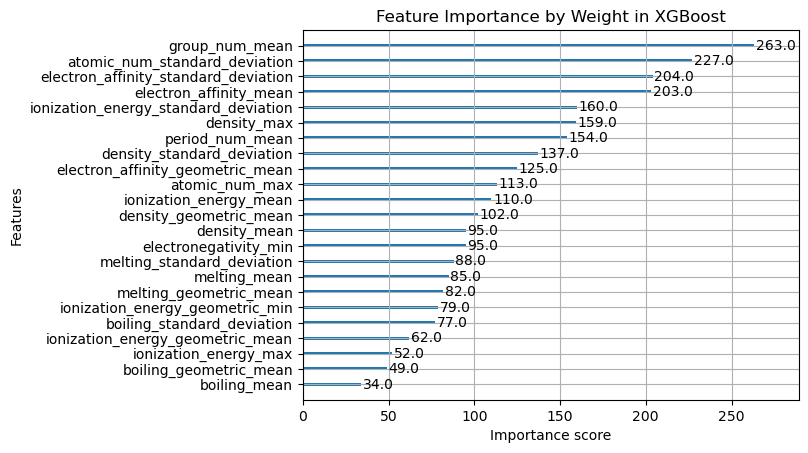

In [87]:
plot_importance(model, importance_type='weight', title='Feature Importance by Weight')
plt.title("Feature Importance by Weight in XGBoost")

In [88]:
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of trees to build
    'learning_rate': [0.01, 0.1, 0.2],            # Step size shrinkage
    'max_depth': [3, 4, 5, 6],                    # Maximum tree depth
    'subsample': [0.8, 1.0],                      # Fraction of rows to sample
    'colsample_bytree': [0.7, 0.8, 1.0],          # Fraction of features to sample (try less than 1 to force randomness)
    'reg_alpha': [0, 0.1, 1],                     # L1 regularization term
    'reg_lambda': [1, 1.5, 2]                     # L2 regularization term
}


In [89]:
xgb_model = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Higher is better, hence negative MSE
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training data
grid_search.fit(X, y)

# Output the best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score (MSE):", -grid_search.best_score_)


Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 0.8}
Best cross-validation score (MSE): 0.5170738789622815


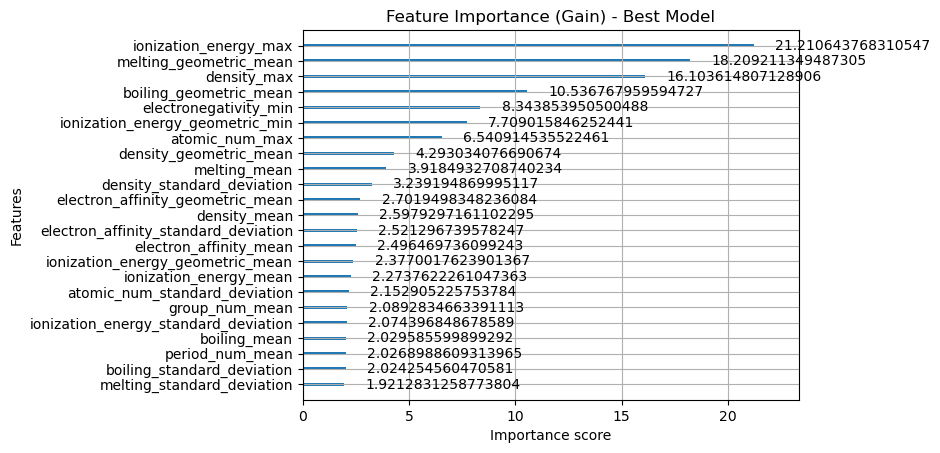

In [90]:
# Create a new model using the best parameters
best_model_with_params = XGBRegressor(**grid_search.best_params_, random_state=42)

# Fit the model to the training data
best_model_with_params.fit(X, y)

# Plot feature importance
plot_importance(best_model_with_params, importance_type='gain')
plt.title("Feature Importance (Gain) - Best Model")
plt.show()

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best Score (Negative MSE): 0.5075959965555299


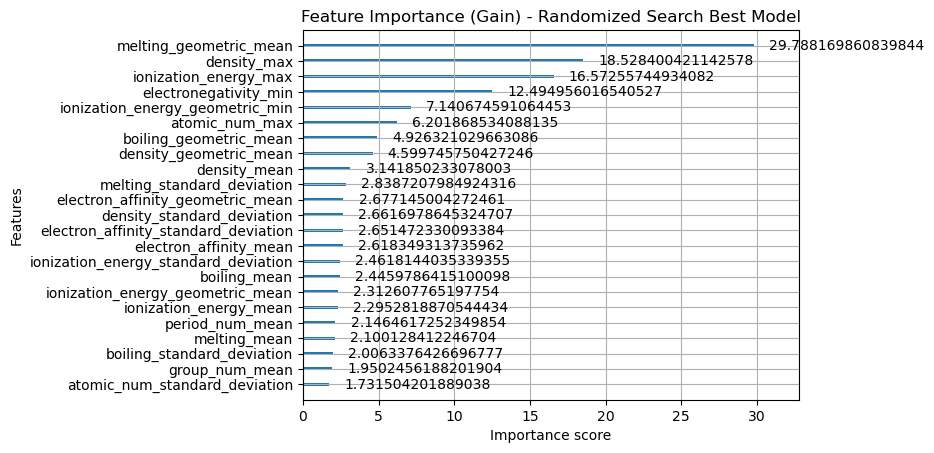

In [91]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=50,  # Number of parameter settings sampled
    cv=kfold,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X, y)

# Display the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score (Negative MSE):", -random_search.best_score_)

# Create a new model using the best parameters
best_random_model = XGBRegressor(**random_search.best_params_, random_state=42)

# Fit the model to the training data
best_random_model.fit(X, y)

# Plot feature importance
plot_importance(best_random_model, importance_type='gain')
plt.title("Feature Importance (Gain) - Randomized Search Best Model")
plt.show()

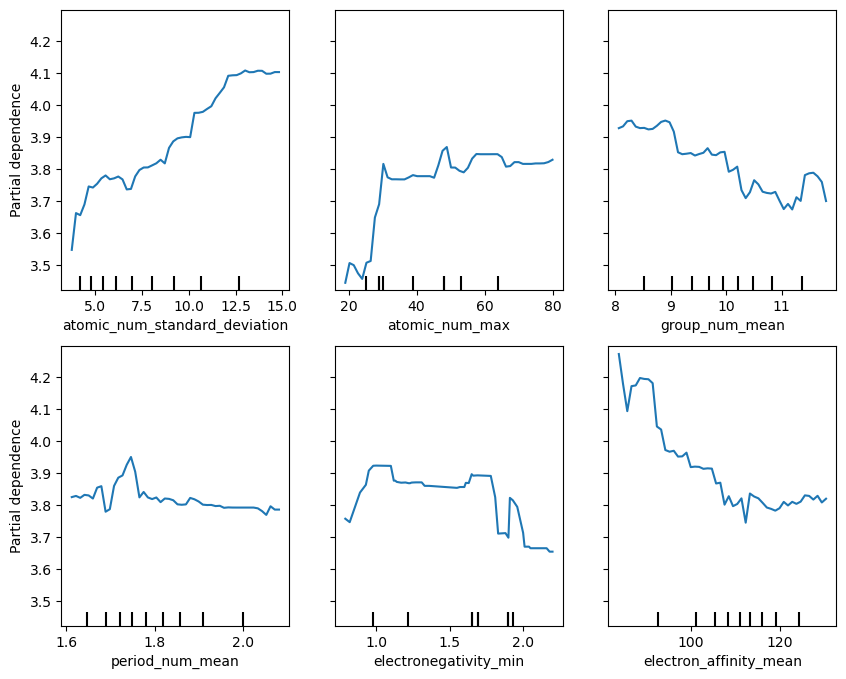

In [92]:


PartialDependenceDisplay.from_estimator(best_model, X, features=X.columns[:6], grid_resolution=50)
plt.gcf().set_size_inches(10, 8)

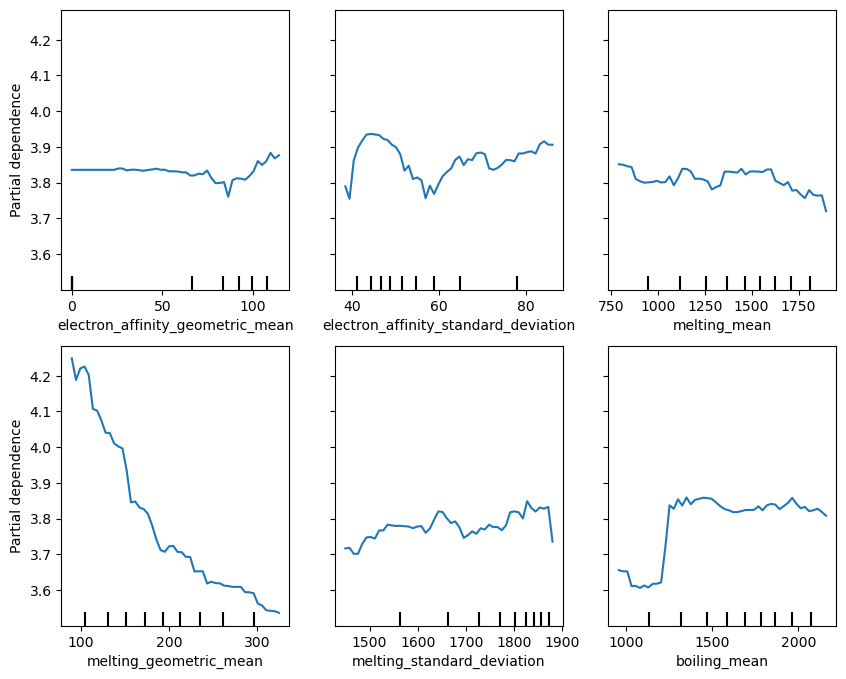

In [93]:

PartialDependenceDisplay.from_estimator(best_model, X, features=X.columns[6:12], grid_resolution=50)
plt.gcf().set_size_inches(10, 8)

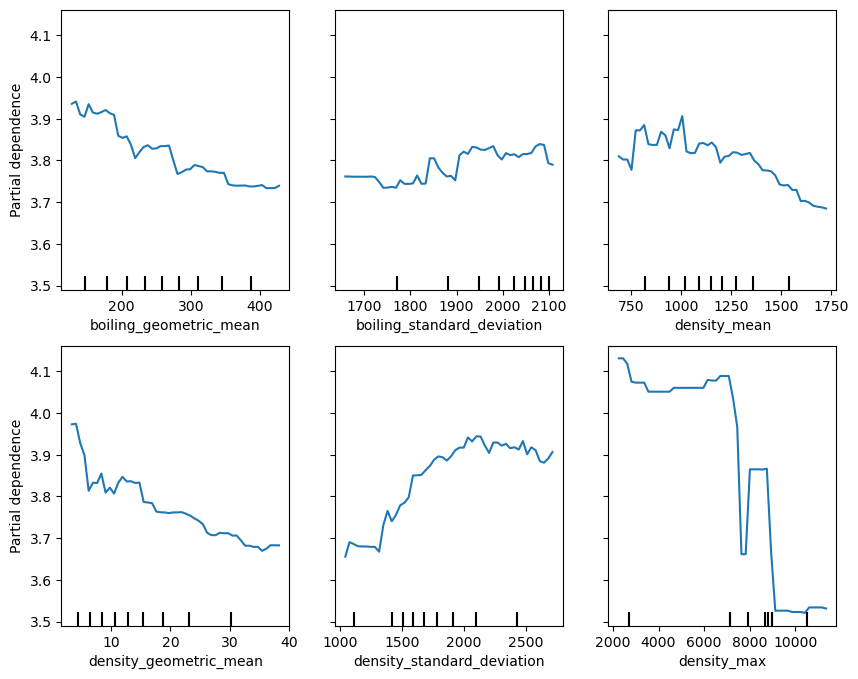

In [94]:

PartialDependenceDisplay.from_estimator(best_model, X, features=X.columns[12:18], grid_resolution=50)
plt.gcf().set_size_inches(10, 8)

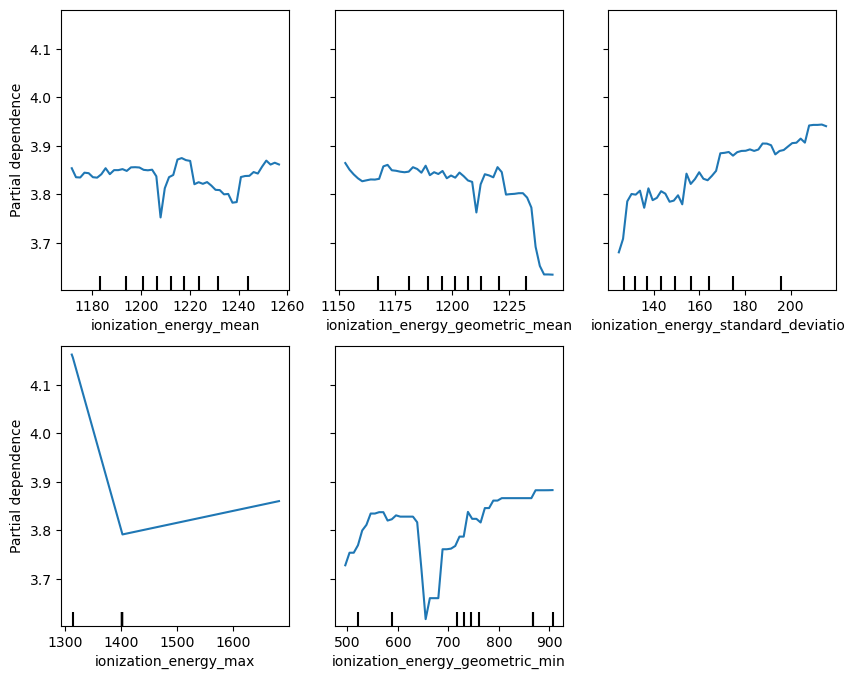

In [95]:

PartialDependenceDisplay.from_estimator(best_model, X, features=X.columns[18:], grid_resolution=50)
plt.gcf().set_size_inches(10, 8)